In [1]:
import pandas as pd
import sklearn
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import numpy as np

In [2]:
crime_property_light_population = pd.read_csv("./model_data/crime_light_density.csv")
crime_property_light_population.fillna(method='ffill', inplace=True)
# crime_property_light_population.dropna(inplace=True)
crime_property_light_population.head()

,Unnamed: 0,OFFENSE_CODE_GROUP,DISTRICT,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET,Lat,Long,zipcode,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density
0,0,Auto Theft,E18,N,2019-10-13 09:28:24,2019,10,Sunday,9,LINCOLN ST,42.259518,-71.121563,2136,6206.9,455.644447,21.073507,0.437849
1,1,Auto Theft,E18,N,2019-10-12 20:11:26,2019,10,Saturday,20,METROPOLITAN AVE,42.262092,-71.116710,2136,6206.9,455.644447,21.073507,0.437849
2,2,Auto Theft,D14,N,2019-10-12 15:12:43,2019,10,Saturday,15,ALLSTON ST,42.352375,-71.135096,2134,16212.0,2250.588503,63.554783,0.582893
3,3,Auto Theft,D4,N,2019-10-12 04:41:52,2019,10,Saturday,4,SAINT JAMES AVE,42.349476,-71.076402,2116,32724.1,14799.401260,480.463801,0.656585
4,4,Auto Theft,A15,N,2019-10-02 08:08:49,2019,10,Wednesday,8,N MEAD ST,42.381846,-71.066551,2129,12192.0,278.377510,165.249738,0.678941


In [3]:
predictors = ['OFFENSE_CODE_GROUP','SHOOTING', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'Population density (per square mile of land area)', \
              'BLDG_VAL', 'LAND_VAL','light_density', 'Lat', 'Long']
# predictors = ['OFFENSE_CODE_GROUP','SHOOTING', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'Population density (per square mile of land area)', 'BLDG_VAL', 'LAND_VAL','light_density']

df = crime_property_light_population[predictors]

crime_type = ['Auto Theft', 'Motor Vehicle Accident Response', 'Larceny', 'Robbery', 'Residential Burglary']

df = df[df['OFFENSE_CODE_GROUP'].isin(crime_type)]

# count of each type before balancing
print(df.OFFENSE_CODE_GROUP.value_counts())

Motor Vehicle Accident Response    40471
Larceny                            33610
Residential Burglary                6857
Auto Theft                          5766
Robbery                             5264
Name: OFFENSE_CODE_GROUP, dtype: int64


In [4]:
df.shape

(91968, 11)

In [5]:
# add light data's lat long
# add graffiti data's lat long
# analyze the max and min of the concatenated lat long respectively
# bin it
# merge with binning 
from sklearn.preprocessing import KBinsDiscretizer

grid_lat = np.linspace(42, 42.4, 192, endpoint='False')
grid_lat_pd = pd.DataFrame(grid_lat)
#Boston City
#21.96 km wide ==> 220 bins , 100m grid
#19.20 km long ==> 192 bins, 100m grid
#########################
lat_bin_count = 192 // 4 
long_bin_count = 220 // 4
#########################

lat_enc = KBinsDiscretizer(n_bins=lat_bin_count, strategy='uniform', encode='ordinal')
long_enc = KBinsDiscretizer(n_bins=long_bin_count, strategy='uniform', encode='ordinal')

#left most: 42.281549, -71.191510
#right most: 42.325468, -70.922188

#southern most: 42.227155, -71.130342
#northern most: 42.397988, -71.000505
# Boston City's Rectangular boundary:

# lat : 42.227155 ~ 42.397988
# long : -71.191510 ~ -70.922188

boston_west = -71.191512
boston_east = -70.922185
boston_north = 42.397990
boston_south = 42.227150


df = df[df['Lat'] <= 42.397990]
df = df[df['Lat'] >= 42.227150]


df = df[df['Long'] <= -70.922185]
df = df[df['Long'] >= -71.191512]
print(len(df)) # result : 147858 ==> we don't lose any data (all rows are accurate)


df["latbin"] = lat_enc.fit_transform(pd.DataFrame(df.Lat))
df["longbin"] = long_enc.fit_transform(pd.DataFrame(df.Long))

# df["lonbin"] = df.Longitude.map(to_bin)
# groups = df.groupby(("latbin", "lonbin"))
# print((boston_north - boston_south) / 192.0  * 161 + boston_south)
df.head()

91968


,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,Long,latbin,longbin
0,Auto Theft,N,10,Sunday,9,6206.9,455.644447,21.073507,0.437849,42.259518,-71.121563,8.0,17.0
1,Auto Theft,N,10,Saturday,20,6206.9,455.644447,21.073507,0.437849,42.262092,-71.116710,8.0,18.0
2,Auto Theft,N,10,Saturday,15,16212.0,2250.588503,63.554783,0.582893,42.352375,-71.135096,35.0,13.0
3,Auto Theft,N,10,Saturday,4,32724.1,14799.401260,480.463801,0.656585,42.349476,-71.076402,34.0,30.0
4,Auto Theft,N,10,Wednesday,8,12192.0,278.377510,165.249738,0.678941,42.381846,-71.066551,44.0,33.0


In [6]:
light = pd.read_csv('./model_data/streetlight_locations.csv')
light = light[["Lat", "Long"]]

light["latbin"] =  lat_enc.fit_transform(pd.DataFrame(light.Lat))
light["longbin"] =  long_enc.fit_transform(pd.DataFrame(light.Long))
light.head()

light_count = pd.DataFrame(light.groupby(['latbin', 'longbin']).size())


light_count.columns = ['light_count']

light_count.to_csv("light_count.csv")
light2 = pd.read_csv('./light_count.csv')

print(light2["light_count"].max())

df = df.join(light2.set_index(['latbin', 'longbin']), on=['latbin', 'longbin'])

df["light_count"] = df["light_count"].fillna(0)
df.head()

492


,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,Long,latbin,longbin,light_count
0,Auto Theft,N,10,Sunday,9,6206.9,455.644447,21.073507,0.437849,42.259518,-71.121563,8.0,17.0,12.0
1,Auto Theft,N,10,Saturday,20,6206.9,455.644447,21.073507,0.437849,42.262092,-71.116710,8.0,18.0,0.0
2,Auto Theft,N,10,Saturday,15,16212.0,2250.588503,63.554783,0.582893,42.352375,-71.135096,35.0,13.0,55.0
3,Auto Theft,N,10,Saturday,4,32724.1,14799.401260,480.463801,0.656585,42.349476,-71.076402,34.0,30.0,192.0
4,Auto Theft,N,10,Wednesday,8,12192.0,278.377510,165.249738,0.678941,42.381846,-71.066551,44.0,33.0,8.0


# Below is grid scaling for bldg value ==> not so effective

In [7]:
# bldg = pd.read_csv('./model_data/union_2019_building_value.csv')
# bldg = bldg[["BLDG_VAL", "0", "1"]]
# bldg = bldg.dropna()
# bldg = bldg.rename(columns={"BLDG_VAL": "avg_BLDG_val", "0": "latitude", "1":"longitude"})
# print(len(bldg))
# bldg["latitude"] = bldg["latitude"].astype(float)
# # bldg["latitude"] = pd.to_numeric(df["latitude"],errors='coerce')
# bldg["longitude"] = bldg["longitude"].astype(float)


# bldg["latbin"] =  lat_enc.fit_transform(pd.DataFrame(bldg.latitude))
# bldg["longbin"] =  long_enc.fit_transform(pd.DataFrame(bldg.longitude))

# print(bldg['latbin'].unique())

# print(bldg[bldg['latbin']<42] .head())

# bldg_val_avg = pd.DataFrame(bldg.groupby(['latbin', 'longbin']).mean())
# bldg_val_avg.drop(['latitude', 'longitude' ], axis=1, inplace=True)
# print(bldg_val_avg.head())

# bldg_val_avg.to_csv("2019_avg_bldg_val.csv")

# bldg_val_avg2 = pd.read_csv('./2019_avg_bldg_val.csv')

# df = df.join(bldg_val_avg2.set_index(['latbin', 'longbin']), on=['latbin', 'longbin'])

# df["avg_BLDG_val"] = df["avg_BLDG_val"].fillna(0)
# df.head()

In [8]:
graffiti = pd.read_csv('./clean_data/boston_graffiti.csv')
graffiti = graffiti[graffiti["reason"] == 'Graffiti' ]
# graffiti.head()

graffiti["latbin"] =  lat_enc.fit_transform(pd.DataFrame(graffiti.latitude))
graffiti["longbin"] =  long_enc.fit_transform(pd.DataFrame(graffiti.longitude))
graffiti.head()

print(graffiti['latbin'].unique())

graffiti_count = pd.DataFrame(graffiti.groupby(['latbin', 'longbin']).size())

graffiti_count.columns = ['graffiti_count']

print(graffiti_count.head())
graffiti_count.to_csv("graffiti_count.csv")

[23. 20. 33. 22. 37. 34. 21. 42. 19. 18. 26. 35. 39. 32. 44. 27. 36. 38.
 25. 31. 46. 24. 40. 15. 16. 45. 29. 11. 17. 30. 28.  4. 14.  7. 10. 12.
  9.  6.  3.  1. 43. 13.  2. 41.  5. 47.  8.  0.]
                graffiti_count
latbin longbin                
0.0    14.0                  1
1.0    13.0                  1
       14.0                  5
       15.0                  1
       16.0                  1


In [9]:
graffiti2 = pd.read_csv('./graffiti_count.csv')

print(graffiti2["graffiti_count"].max())

df = df.join(graffiti2.set_index(['latbin', 'longbin']), on=['latbin', 'longbin'])

df["graffiti_count"] = df["graffiti_count"].fillna(0)
df.head()

4387


,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,Long,latbin,longbin,light_count,graffiti_count
0,Auto Theft,N,10,Sunday,9,6206.9,455.644447,21.073507,0.437849,42.259518,-71.121563,8.0,17.0,12.0,1.0
1,Auto Theft,N,10,Saturday,20,6206.9,455.644447,21.073507,0.437849,42.262092,-71.116710,8.0,18.0,0.0,3.0
2,Auto Theft,N,10,Saturday,15,16212.0,2250.588503,63.554783,0.582893,42.352375,-71.135096,35.0,13.0,55.0,73.0
3,Auto Theft,N,10,Saturday,4,32724.1,14799.401260,480.463801,0.656585,42.349476,-71.076402,34.0,30.0,192.0,97.0
4,Auto Theft,N,10,Wednesday,8,12192.0,278.377510,165.249738,0.678941,42.381846,-71.066551,44.0,33.0,8.0,9.0


In [10]:
# data balancing
crime_MVAR = df[df['OFFENSE_CODE_GROUP']=="Motor Vehicle Accident Response"]
crime_Larceny  = df[df['OFFENSE_CODE_GROUP']=="Larceny"]
crime_other_crime = df[(df['OFFENSE_CODE_GROUP']!="Motor Vehicle Accident Response") & (df['OFFENSE_CODE_GROUP']!="Larceny")]

#  keep about 6000 row for each crime
drop_MVAR, keep_MVAR = train_test_split(crime_MVAR, test_size=6000/len(crime_MVAR), random_state = 109, stratify = crime_MVAR[['MONTH', 'DAY_OF_WEEK']])
drop_Larceny, keep_Larceny = train_test_split(crime_Larceny, test_size=6000/len(crime_Larceny), random_state = 109, stratify = crime_Larceny[['MONTH', 'DAY_OF_WEEK']])

# combine data
balanced_data = pd.concat([keep_MVAR, keep_Larceny, crime_other_crime])

# count of each type after balancing 
balanced_data.OFFENSE_CODE_GROUP.value_counts()

Residential Burglary               6857
Larceny                            6000
Motor Vehicle Accident Response    6000
Auto Theft                         5766
Robbery                            5264
Name: OFFENSE_CODE_GROUP, dtype: int64

In [26]:
balanced_data.to_csv('balanced_data.csv')

In [12]:
#Let's label encode & one-hot encode the Categoricals (SHOOTING, DAY_OF_WEEK)
df = balanced_data
enc = OneHotEncoder(handle_unknown='ignore')

le = LabelEncoder() 
  
df['SHOOTING']= le.fit_transform(df['SHOOTING'])
df['DAY_OF_WEEK']= le.fit_transform(df['DAY_OF_WEEK']) 
df['OFFENSE_CODE_GROUP'] = le.fit_transform(df['OFFENSE_CODE_GROUP'])
df.reset_index(drop=True, inplace=True)

df_cat = enc.fit_transform(df[["SHOOTING", "MONTH", "DAY_OF_WEEK", "HOUR"]]).toarray()
df_cat = pd.DataFrame(df_cat, columns=enc.get_feature_names(['SHOOTING', 'MONTH', 'DAY_OF_WEEK', 'HOUR']))
df_cat.reset_index(drop=True, inplace=True)

df = pd.concat([df, df_cat], axis=1)
# print(df_cat.head())
df.head()

,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,2,0,7,0,23,19926.9,560.432683,189.333050,1.000000,42.343765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,0,8,5,12,15871.3,4156.595899,36.813618,0.684760,42.320755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,7,3,5,24456.0,3738.859654,105.378164,0.783085,42.324012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0,8,1,16,11553.7,121.169778,34.318379,0.548610,42.290953,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0,8,0,18,19926.9,560.432683,189.333050,1.000000,42.338655,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Dropping duplicate features (due to grid scaling)

In [13]:
df.drop(['light_density'], axis=1, inplace=True)
df.drop(['latbin'], axis=1, inplace=True)
df.drop(['longbin'], axis=1, inplace=True)
df.drop(['BLDG_VAL'], axis=1, inplace=True)
df.drop(['SHOOTING'], axis=1, inplace=True)


In [14]:
df.head()

,OFFENSE_CODE_GROUP,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),LAND_VAL,Lat,Long,light_count,graffiti_count,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,2,7,0,23,19926.9,189.333050,42.343765,-71.088669,165.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,8,5,12,15871.3,36.813618,42.320755,-71.090354,103.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,7,3,5,24456.0,105.378164,42.324012,-71.108921,146.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,8,1,16,11553.7,34.318379,42.290953,-71.046736,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,8,0,18,19926.9,189.333050,42.338655,-71.081457,151.0,84.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'OFFENSE_CODE_GROUP'], 
                                                         df.OFFENSE_CODE_GROUP, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.OFFENSE_CODE_GROUP)

In [16]:
#Let's scale the variables
min_max_scaler = MinMaxScaler()

# standard_scaler = StandardScaler()

# numerical = ["Population density (per square mile of land area)", "BLDG_VAL", "LAND_VAL", "light_density"]
to_standardize = ['Population density (per square mile of land area)','BLDG_VAL', 'LAND_VAL', 'Lat', 'Long', 'latbin', 'longbin', 'light_count',
       'avg_BLDG_val', 'graffiti_count']
not_standardize = list(df_cat.columns)
not_standardize.append('SHOOTING')
not_standardize.append('MONTH')
not_standardize.append('DAY_OF_WEEK')
not_standardize.append('HOUR')

min_max_scaler.fit(X_train)

# standard_scaler.fit(X_train[to_standardize])

X_normalized = pd.DataFrame(min_max_scaler.transform(X_train))
# X_normalized = pd.concat([pd.DataFrame(standard_scaler.transform(X_train[to_standardize])),
#                          pd.DataFrame(X_train[not_standardize])]
#                          , axis=1 )

X_normalized.columns = X_train.columns
X_normalized_tst = pd.DataFrame(min_max_scaler.transform(X_test))
# X_normalized_tst = pd.concat([pd.DataFrame(standard_scaler.transform(X_test[to_standardize])),
#                          pd.DataFrame(X_test[not_standardize])]
#                          , axis=1 )

X_normalized_tst.columns = X_test.columns


# X_normalized.drop(['SHOOTING'], axis=1, inplace=True)
# X_normalized_tst.drop(['SHOOTING'], axis=1, inplace=True)
X_normalized.drop(['MONTH'], axis=1, inplace=True)
X_normalized_tst.drop(['MONTH'], axis=1, inplace=True)
X_normalized.drop(['DAY_OF_WEEK'], axis=1, inplace=True)
X_normalized_tst.drop(['DAY_OF_WEEK'], axis=1, inplace=True)
X_normalized.drop(['HOUR'], axis=1, inplace=True)
X_normalized_tst.drop(['HOUR'], axis=1, inplace=True)
X_normalized.head()

,Population density (per square mile of land area),LAND_VAL,Lat,Long,light_count,graffiti_count,SHOOTING_0,SHOOTING_1,MONTH_1,MONTH_2,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,0.154628,0.033820,0.433305,0.339132,0.000000,0.000684,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.216769,0.013439,0.503961,0.552157,0.128280,0.001596,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.584859,0.411953,0.714781,0.450810,0.565598,0.020059,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.476578,0.606003,0.725942,0.552276,0.358601,0.109642,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.231142,0.020764,0.563188,0.585568,0.000000,0.007066,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
X_normalized.drop(['SHOOTING_0', 'MONTH_1', 'DAY_OF_WEEK_0', 'HOUR_0'], axis=1, inplace=True)
X_normalized_tst.drop(['SHOOTING_0', 'MONTH_1', 'DAY_OF_WEEK_0', 'HOUR_0'], axis=1, inplace=True)
X_normalized

,Population density (per square mile of land area),LAND_VAL,Lat,Long,light_count,graffiti_count,SHOOTING_1,MONTH_2,MONTH_3,MONTH_4,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,0.154628,0.033820,0.433305,0.339132,0.000000,0.000684,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.216769,0.013439,0.503961,0.552157,0.128280,0.001596,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.584859,0.411953,0.714781,0.450810,0.565598,0.020059,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.476578,0.606003,0.725942,0.552276,0.358601,0.109642,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.231142,0.020764,0.563188,0.585568,0.000000,0.007066,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23904,0.167550,0.010112,0.265494,0.325811,0.026239,0.000228,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23905,0.231142,0.020764,0.508085,0.639332,0.000000,0.004787,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23906,0.167550,0.010112,0.254422,0.342479,0.049563,0.002735,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23907,0.229294,0.116790,0.606933,0.719079,0.000000,0.001140,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Best so far Log : 32.33 ( bin factor :4)

In [18]:
# balanced data
# Let's first start with Logistic Model

logreg = LogisticRegression(random_state = 0, solver='lbfgs', multi_class='multinomial', max_iter = 1000)
logreg.fit(X_normalized, y_train)
y_pred = logreg.predict(X_normalized_tst)

mcm = multilabel_confusion_matrix(y_test, y_pred, sample_weight=None, labels=None, samplewise=False)
logreg.score(X_normalized_tst , y_test)

0.3225158916025427

In [19]:
logreg.score(X_normalized, y_train)

0.32523317579154293

In [20]:
# knn = KNeighborsClassifier(n_neighbors = 7).fit(X_normalized, y_train) 
  
# # accuracy on X_test 
# accuracy = knn.score(X_normalized_tst, y_test) 
# print(accuracy)

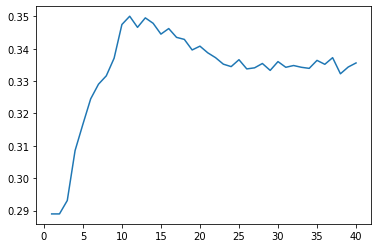

In [21]:
# decision tree with best depth by cv
depth_list = range(1,41)
score_list = []

for depth in depth_list:
#     print(depth)
    clf = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=depth)
    score = np.mean(cross_val_score(clf, X_normalized, y_train, cv=5))
    score_list.append(score)
plt.plot(depth_list, score_list)
plt.show()

In [22]:
best_depth = depth_list[np.argmax(score_list)]
best_depth

11

In [23]:
clf = DecisionTreeClassifier(random_state=0, max_depth=best_depth)
clf.fit(X_normalized, y_train)
clf.score(X_normalized_tst, y_test)

0.3546336567413851

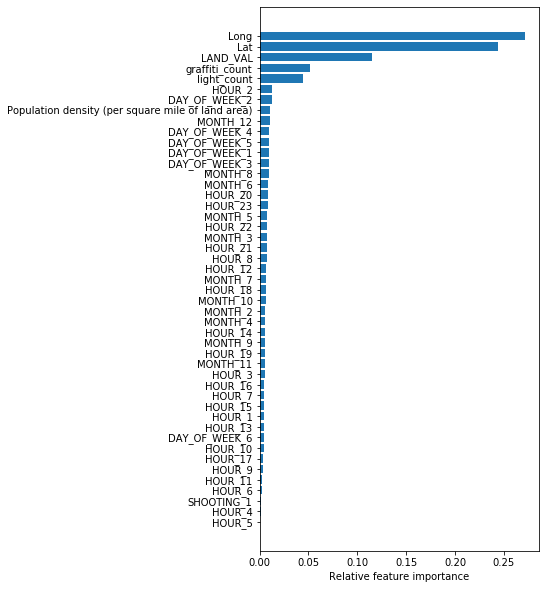

In [24]:
# plot feature importances
plt.figure(figsize=(5,10))
features = X_normalized.columns
feature_importances = clf.feature_importances_
idx = np.argsort(feature_importances)
plt.barh(y=features[idx], width=feature_importances[idx])
plt.xlabel("Relative feature importance")
plt.show()